# Obejct_detection

Writer: E.W

## Intro

In this notebook, I will detect african-wildlifes with YOLO v8. There are three jobs awaiting:
1. Organize the data for training and inferencing
2. Fine tuning YOLO v8 and check model performance
3. Display all or sepecific objects detected 

## Data Preprocessing

In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import cv2
import random

First, we need to prepare our data. The image data of this dataset is jpg and text data is formatted as YOLO asks. I don't need to do more changes on it but split them into train, validation and test.

In [4]:
# Creating paths for separate images and labels
curr_path=os.getcwd()
imgtrainpath = os.path.join(curr_path,'images','train')
imgvalpath=os.path.join(curr_path,'images','validation')
imgtestpath=os.path.join(curr_path,'images','test')

labeltrainpath=os.path.join(curr_path,'labels','train')
labelvalpath=os.path.join(curr_path,'labels','validation')
labeltestpath=os.path.join(curr_path,'labels','test')

# Creating directories for all paths defined
os.makedirs(imgtrainpath)
os.makedirs(imgvalpath)
os.makedirs(imgtestpath)
os.makedirs(labeltrainpath)
os.makedirs(labelvalpath)
os.makedirs(labeltestpath)

In [13]:
BASE_PATH = '/kaggle/input/african-wildlife'
IMAGE_SIZE = 640
for dirname in os.listdir(BASE_PATH):
    dirpath=os.path.join(BASE_PATH, dirname)
    for file in os.listdir(dirpath):
        filepath=os.path.join(dirpath, file)
        newname=dirname+'_'+file
        if file.endswith((".txt")): 
            shutil.copy(filepath, labeltrainpath)
            path=os.path.join(labeltrainpath, file)
            newpath=os.path.join(labeltrainpath, newname)
        elif file.endswith((".jpg", ".JPG")): 
            img_resized=cv2.resize(cv2.imread(filepath), (IMAGE_SIZE, IMAGE_SIZE))
            path=os.path.join(imgtrainpath, file)
            cv2.imwrite(path, img_resized)
            newpath=os.path.join(imgtrainpath, newname)
        os.rename(path, newpath) # Rename the file (label or image)

In [14]:
# Checking the size of train dataset
len(os.listdir(imgtrainpath)), len(os.listdir(labeltrainpath))

(1504, 1504)

There is one concern I have that there may be multiple objects in one image. They are perfect test images for the last job, object detection. So, the first thing to do is finding them and put it away.

In [15]:
for file in os.listdir(labeltrainpath):
    classes_set=set()
    with open(os.path.join(labeltrainpath, file), "r") as f:
        for line in f:
            class_id,_,_,_,_=line.strip().split(" ")
            classes_set.add(class_id)
    if len(classes_set) > 1:
        filepath=os.path.join(labeltrainpath, file)
        newpath=os.path.join(labeltestpath, file)
        shutil.move(filepath, newpath) # moving label file to test path
        basename=os.path.splitext(file)[0]
        print(basename) # printing the image name
        imgfilename=basename+'.jpg'
        oldimgfilepath=os.path.join(imgtrainpath, imgfilename)
        newimgfilepath=os.path.join(imgtestpath, imgfilename) 
        shutil.move(oldimgfilepath, newimgfilepath) # moving image to test path

buffalo_291
elephant_290
buffalo_300
elephant_288
buffalo_301
zebra_338
elephant_345
elephant_291
buffalo_273
rhino_375
zebra_339
buffalo_297
rhino_238
zebra_073
rhino_256
elephant_166
buffalo_298
buffalo_299


In [24]:
# Checking the size of test dataset
len(os.listdir(imgtestpath)), len(os.listdir(labeltestpath))

(18, 18)

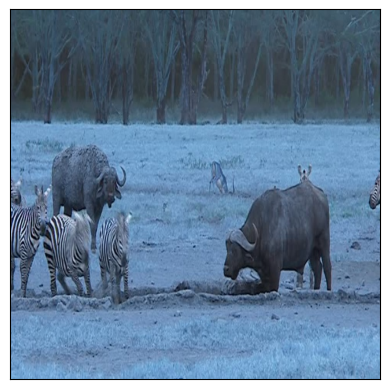

In [26]:
# Pick one image to show
plt.imshow(cv2.imread('/kaggle/working/images/test/buffalo_297.jpg')) 
plt.xticks([])
plt.yticks([])
plt.show()

In [29]:
# train/validation dataset split

factor=0.2 

for file in random.sample(os.listdir(imgtrainpath), int(len(os.listdir(imgtrainpath))*factor)):
    basename=os.path.splitext(file)[0]
    textfilename=basename+'.txt'
    labelfilepath=os.path.join(labeltrainpath, textfilename)
    labeldestpath=os.path.join(labelvalpath, textfilename)
    imgfilepath=os.path.join(imgtrainpath, file)
    imgdestpath=os.path.join(imgvalpath, file)
    shutil.move(imgfilepath, imgdestpath)
    shutil.move(labelfilepath, labeldestpath)

In [30]:
# Checking the size of validation dataset
len(os.listdir(imgvalpath)), len(os.listdir(labelvalpath))

(297, 297)

## Modeling

In [5]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 28.0 MB/s eta 0:00:00


In [31]:
from ultralytics import YOLO
# Using YOLO's pretrained model architecture and weights for training
model=YOLO('yolov8m.yaml').load('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:01<00:00, 50.7MB/s]


Transferred 475/475 items from pretrained weights


In [33]:
config_content = f"""
train: {imgtrainpath}
val: {imgvalpath}
test: {imgtestpath}

nc: 4

names:
  0: buffle
  1: elephant
  2: rhino
  3: zebra
"""

# Write the configuration to the file
with open("african_wildlife.yaml", "w") as f:
    f.write(config_content)

In [35]:
# Training the model
config_path = '/kaggle/working/african_wildlife.yaml'
model.train(data=config_path, epochs=100, 
            imgsz=640, batch=16, name='african_wildlife_detection')

Ultralytics YOLOv8.2.48 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/kaggle/working/african_wildlife.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=african_wildlife_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 162MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/labels/train... 1189 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1189/1189 [00:00<00:00, 1360.46it/s]

train: New cache created: /kaggle/working/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/labels/validation... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<00:00, 1427.31it/s]

val: New cache created: /kaggle/working/labels/validation.cache


Plotting labels to runs/detect/african_wildlife_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/african_wildlife_detection
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.94G     0.8974      1.699      1.365         21        640: 100%|██████████| 75/75 [00:47<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


                   all        297        555      0.559      0.485        0.5      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.67G      1.148      1.594      1.535         22        640: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


                   all        297        555      0.299      0.399      0.286      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.66G      1.226      1.609      1.577         24        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


                   all        297        555      0.428      0.416      0.385      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.65G      1.235       1.57      1.575         18        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        297        555      0.518      0.414      0.448      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.67G      1.207      1.514      1.559         10        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


                   all        297        555      0.519      0.445      0.424       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.56G      1.121       1.36      1.467         20        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        297        555      0.623      0.619      0.618      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.66G      1.106      1.335      1.473         21        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.751      0.655      0.744      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.64G      1.063      1.252      1.439         22        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.743      0.517      0.655      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.66G      1.018       1.22      1.416          8        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        297        555      0.744      0.629      0.729      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.56G      1.023      1.219      1.421         14        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.803      0.681      0.803      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.67G     0.9817      1.085      1.368         32        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.839      0.716      0.838      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.84G     0.9741      1.102       1.37         15        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.766      0.796       0.85      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.69G      0.935      1.048      1.352         13        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.861       0.77       0.85      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.55G     0.9259      1.037      1.341         17        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.858      0.788      0.872      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.67G     0.9127      1.012      1.332         14        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

                   all        297        555      0.844      0.798      0.869      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.65G     0.8991     0.9799      1.326         23        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

                   all        297        555      0.823      0.822      0.878      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.65G     0.8881     0.9682      1.314         15        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

                   all        297        555      0.853      0.829      0.887      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.56G     0.8701     0.9325      1.302         15        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.909       0.82      0.913      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.67G     0.8516     0.9177      1.292         12        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.791       0.81      0.847      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.64G     0.8508     0.9009      1.292         16        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.875      0.826        0.9      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.68G     0.8529     0.8779        1.3         19        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.879      0.841      0.904      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.55G     0.8163     0.8445      1.267         16        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.927      0.832      0.906      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.66G     0.8301     0.8639      1.275         23        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        297        555      0.895       0.83      0.919      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.64G     0.8065     0.8312      1.268         23        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555       0.86      0.845      0.907      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.68G     0.8306     0.8463      1.285         17        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.886      0.845      0.922      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.55G     0.8033     0.8081       1.25         31        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

                   all        297        555      0.925      0.815      0.918      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.67G     0.8143     0.8143      1.262         17        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.887      0.891       0.94      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.66G     0.7952     0.8096      1.253         21        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.856      0.825      0.891      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.88G     0.7884     0.7926      1.239         37        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.881      0.853      0.923      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.55G     0.7616     0.7698      1.224         24        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.893      0.819      0.919      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.67G     0.7559     0.7471       1.22         20        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.923      0.848      0.928      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.85G     0.7522     0.7317       1.23         17        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.929      0.854      0.922       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.67G     0.7825     0.7325      1.235         15        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.919      0.832      0.926      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.56G     0.7516     0.7232      1.221         14        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

                   all        297        555      0.904      0.888      0.937      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.66G      0.738      0.737      1.205         24        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.894      0.876      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.64G     0.7368     0.7385      1.209         17        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.916       0.87       0.93      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.68G     0.7369     0.7025      1.217         22        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.931      0.858      0.941      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.55G     0.7321      0.703      1.204         16        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.906       0.87      0.941      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.67G     0.7217     0.7271      1.199         18        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.926       0.87      0.939      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.86G     0.7226     0.6846      1.203         22        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

                   all        297        555      0.902       0.91      0.948      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.88G     0.6913      0.661       1.17         13        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555        0.9      0.881      0.944       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.55G     0.7117     0.6689      1.185         27        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

                   all        297        555       0.91      0.891      0.955      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.66G     0.7064     0.6605      1.177         21        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.925      0.889      0.944      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.65G     0.6744     0.6464      1.172         15        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.947       0.88      0.955      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.67G     0.6818      0.623       1.17         28        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.926      0.877      0.951      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.55G     0.6745     0.6196      1.163         16        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.935      0.852      0.943       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.88G     0.6796     0.6183      1.168         20        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.912      0.879      0.942       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.64G     0.6701     0.6143      1.159         25        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

                   all        297        555      0.933      0.869       0.95      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.67G     0.6882     0.6105      1.183         13        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.946      0.874      0.948      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.56G     0.6581     0.6225      1.147         12        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

                   all        297        555      0.928      0.869      0.939      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.67G     0.6659     0.5979      1.148         16        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.942      0.879      0.946       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.65G     0.6625     0.6078      1.152         27        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555       0.93      0.878      0.947      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.68G     0.6548     0.6082      1.156         18        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.911      0.891      0.941      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.56G     0.6482     0.5979      1.147          9        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.933      0.877      0.946      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.67G     0.6417     0.5794      1.147         20        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.933      0.901      0.953      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.65G     0.6511      0.586      1.155         13        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.918      0.902      0.948      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.67G     0.6321     0.5594      1.139         18        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.931      0.904       0.96      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.55G     0.6447     0.5569      1.138         22        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.943      0.887       0.95      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.67G     0.6332     0.5755      1.131         11        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.923      0.903      0.956      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.65G     0.6176      0.548      1.122         25        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.926      0.904      0.948      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.67G     0.6178     0.5454      1.124         19        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.915        0.9      0.953      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.55G     0.6112     0.5518      1.123         12        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.941      0.903      0.962      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.66G     0.5879     0.5339       1.11         34        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.946      0.881      0.949      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.85G     0.6067       0.53      1.122         15        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.892      0.911      0.946      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.68G     0.5817       0.51      1.104         17        640: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.942       0.87      0.948      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.55G     0.5972     0.5136       1.11         17        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        297        555       0.93      0.904      0.959      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.88G     0.6013     0.5159      1.115         17        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.934      0.893      0.951      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.65G     0.5851     0.5108      1.105          9        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.922      0.889      0.942      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.87G     0.5872     0.4955      1.107         27        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555       0.94      0.896      0.948      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.55G     0.5823     0.5172      1.107         19        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.909      0.895      0.946      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.66G     0.5716      0.501        1.1         15        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

                   all        297        555      0.927      0.902       0.95        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.86G     0.5905     0.5057      1.115         24        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555       0.94      0.907      0.956      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.68G     0.5638      0.481      1.095         12        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

                   all        297        555      0.927      0.924      0.959      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.55G     0.5563     0.4854      1.085         21        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.928      0.915      0.956      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.67G      0.559     0.4805      1.089         22        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.914      0.912      0.951      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.66G     0.5513     0.4524      1.079         13        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.928       0.91      0.956      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.67G     0.5504     0.4574      1.087         16        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.929      0.902      0.951      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.55G     0.5598     0.4614       1.08         22        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.915      0.903      0.952      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.66G     0.5519     0.4563      1.084         17        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.926      0.901      0.953      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.63G     0.5352     0.4557      1.069         25        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.931      0.897       0.95      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.67G     0.5425     0.4513      1.081         21        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

                   all        297        555      0.958      0.884      0.951      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.55G     0.5379     0.4513      1.074         20        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.947      0.883      0.952      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.66G     0.5249     0.4368      1.067         27        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555       0.95      0.895      0.956      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.65G      0.535     0.4357      1.083         17        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.931      0.909      0.954      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.69G     0.5248      0.422      1.068         15        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.953      0.905      0.954      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.56G     0.5289     0.4465      1.073         19        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.949      0.897      0.951      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.65G     0.5108      0.425      1.061         18        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

                   all        297        555      0.927      0.919      0.952      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.64G     0.5133      0.419      1.055         16        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.947      0.914      0.956      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.66G     0.5022     0.4114      1.046         25        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.939       0.91      0.959      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.56G     0.5109     0.4155      1.064         17        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.943      0.911      0.959      0.823


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.66G     0.3667     0.2621     0.9516         16        640: 100%|██████████| 75/75 [00:46<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        297        555      0.942      0.908      0.955      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.65G     0.3506     0.2478     0.9401          6        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.954      0.895      0.957      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.67G     0.3429     0.2336     0.9343          8        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        297        555      0.931      0.911      0.955      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.55G     0.3366     0.2256     0.9307          7        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.948        0.9      0.957      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.88G     0.3301     0.2321       0.93         11        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.951      0.895      0.958       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.66G     0.3288     0.2243     0.9234         10        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.955      0.885      0.955      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.86G     0.3152     0.2113     0.9111          6        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.935       0.91      0.959      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.55G     0.3233     0.2211     0.9249          8        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        555      0.948      0.914      0.957      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.67G     0.3147     0.2105     0.9097         16        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

                   all        297        555      0.941      0.908      0.954      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.64G     0.3142      0.212      0.911          9        640: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        297        555      0.943      0.916      0.955      0.826



100 epochs completed in 1.425 hours.
Optimizer stripped from runs/detect/african_wildlife_detection/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/african_wildlife_detection/weights/best.pt, 52.0MB

Validating runs/detect/african_wildlife_detection/weights/best.pt...
Ultralytics YOLOv8.2.48 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
YOLOv8m summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


                   all        297        555       0.95      0.895      0.958       0.83
                buffle         65         88      0.987      0.932      0.961      0.872
              elephant         73        159      0.938      0.849      0.939      0.773
                 rhino         75        117      0.961      0.949      0.979      0.897
                 zebra         84        191      0.916      0.852      0.953      0.777
Speed: 0.2ms preprocess, 10.4ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/african_wildlife_detection


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fc5457aa020>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [36]:
def evaluate_map50(trainedmodel, data_path, dataset='val'):
    metrics=trainedmodel.val(data=data_path, split=dataset)
    map50=round(metrics.box.map50, 3)
    print("The mAP of model for all images on {0} dataset is {1}".format(dataset,map50))
    return metrics, map50

In [37]:
# Evaluating val metrics
val_metrics, val_map50=evaluate_map50(model, config_path, dataset='val')

Ultralytics YOLOv8.2.48 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
YOLOv8m summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /kaggle/working/labels/validation.cache... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.90it/s]


                   all        297        555      0.952      0.896      0.958      0.829
                buffle         65         88      0.987      0.932      0.961      0.872
              elephant         73        159      0.939      0.849      0.939      0.771
                 rhino         75        117      0.965      0.953      0.979      0.897
                 zebra         84        191      0.916      0.852      0.953      0.775
Speed: 0.2ms preprocess, 11.3ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs/detect/african_wildlife_detection2
The mAP of model for all images on val dataset is 0.958


The map50 result is good, it shows that the model has a good perfomance. It achieves high precision (0.952) and recall (0.896), indicating accurate detection and comprehensive coverage of objects. The class buffle and rhino exhibit exceptional detection performance with high precision, recall, and mAP scores but for the other two the result is not as good, they can be used to test model in the last job

In [38]:
# function for displaying plots created by YOLO
def display_curves(root_path):
    plt.figure(figsize=(50,50))
    
    #displaying p curve
    p_curve=cv2.imread(os.path.join(root_path,'P_curve.png'))
    ax=plt.subplot(5,1,1)
    plt.imshow(p_curve)
    
    #displaying r curve
    r_curve=cv2.imread(os.path.join(root_path,'R_curve.png'))
    ax=plt.subplot(5,1,2)
    plt.imshow(r_curve)
    
    #displaying pr curve
    pr_curve=cv2.imread(os.path.join(root_path,'PR_curve.png'))
    ax=plt.subplot(5,1,3)
    plt.imshow(pr_curve)
    
    #displaying f1 curve
    f1_curve=cv2.imread(os.path.join(root_path,'F1_curve.png'))
    ax=plt.subplot(5,1,4)
    plt.imshow(f1_curve)
    
    #displaying confusion matrix
    confusion_matrix=cv2.imread(os.path.join(root_path,'confusion_matrix.png'))
    ax=plt.subplot(5,1,5)
    plt.imshow(confusion_matrix)

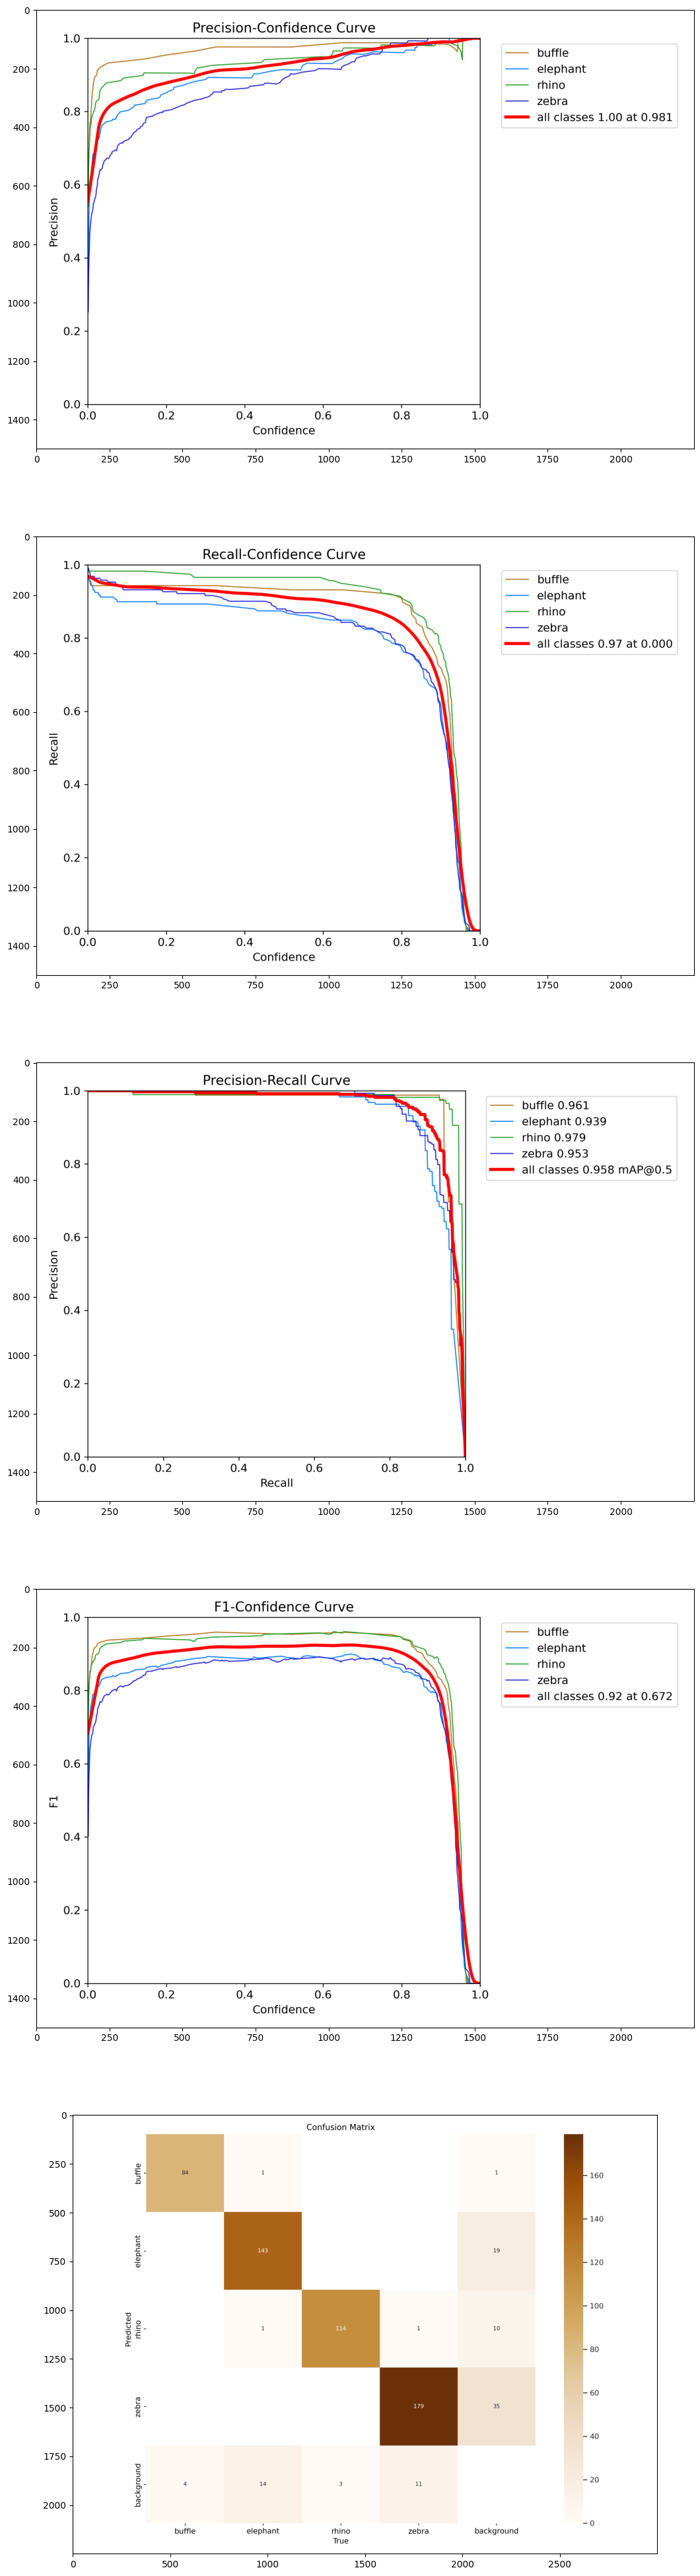

In [39]:
val_path=os.path.join(curr_path, 'runs', 'detect', 'african_wildlife_detection2') 
display_curves(val_path) 

Clearly, these plots prove the conclusion we got.

In [68]:
# Class mapping
label_dict = {"buffle":0,"elephant":1,"rhino":2,"zebra":3}

# Display the obeject detection box
def plot_actual_and_predictions(imgtestpath, model, animal=None):
    plt.figure(figsize=(30, 30))
    test_images = [f for f in os.listdir(imgtestpath)]
    m = random.randint(0, len(test_images) - 1)  # Selecting random image number from the test dataset
    label_id = label_dict[animal] if animal else None
    for i in range(1, 6, 2):
        test_image = os.path.join(imgtestpath, test_images[m])
        ax = plt.subplot(3, 2, i)

        # Display actual image
        plt.imshow(cv2.imread(test_image)) 
        plt.xticks([])
        plt.yticks([])
        plt.title("Actual image", fontsize=40)

        #Make predictionm classes are specified the animal we want to predict
        res = model(test_image,classes = label_id)
        res_plotted = res[0].plot()
        ax = plt.subplot(3, 2, i + 1)

        # Display image with predictions
        plt.imshow(res_plotted)
        plt.title("Image with predictions", fontsize=40)
        plt.xticks([])
        plt.yticks([])

        m = (m + 1) % len(test_images)  # Ensure the index stays within range

    plt.show()


image 1/1 /kaggle/working/images/test/buffalo_299.jpg: 640x640 1 zebra, 15.5ms
Speed: 1.7ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/images/test/zebra_339.jpg: 640x640 4 zebras, 15.4ms
Speed: 1.6ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/images/test/elephant_288.jpg: 640x640 (no detections), 15.4ms
Speed: 1.5ms preprocess, 15.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


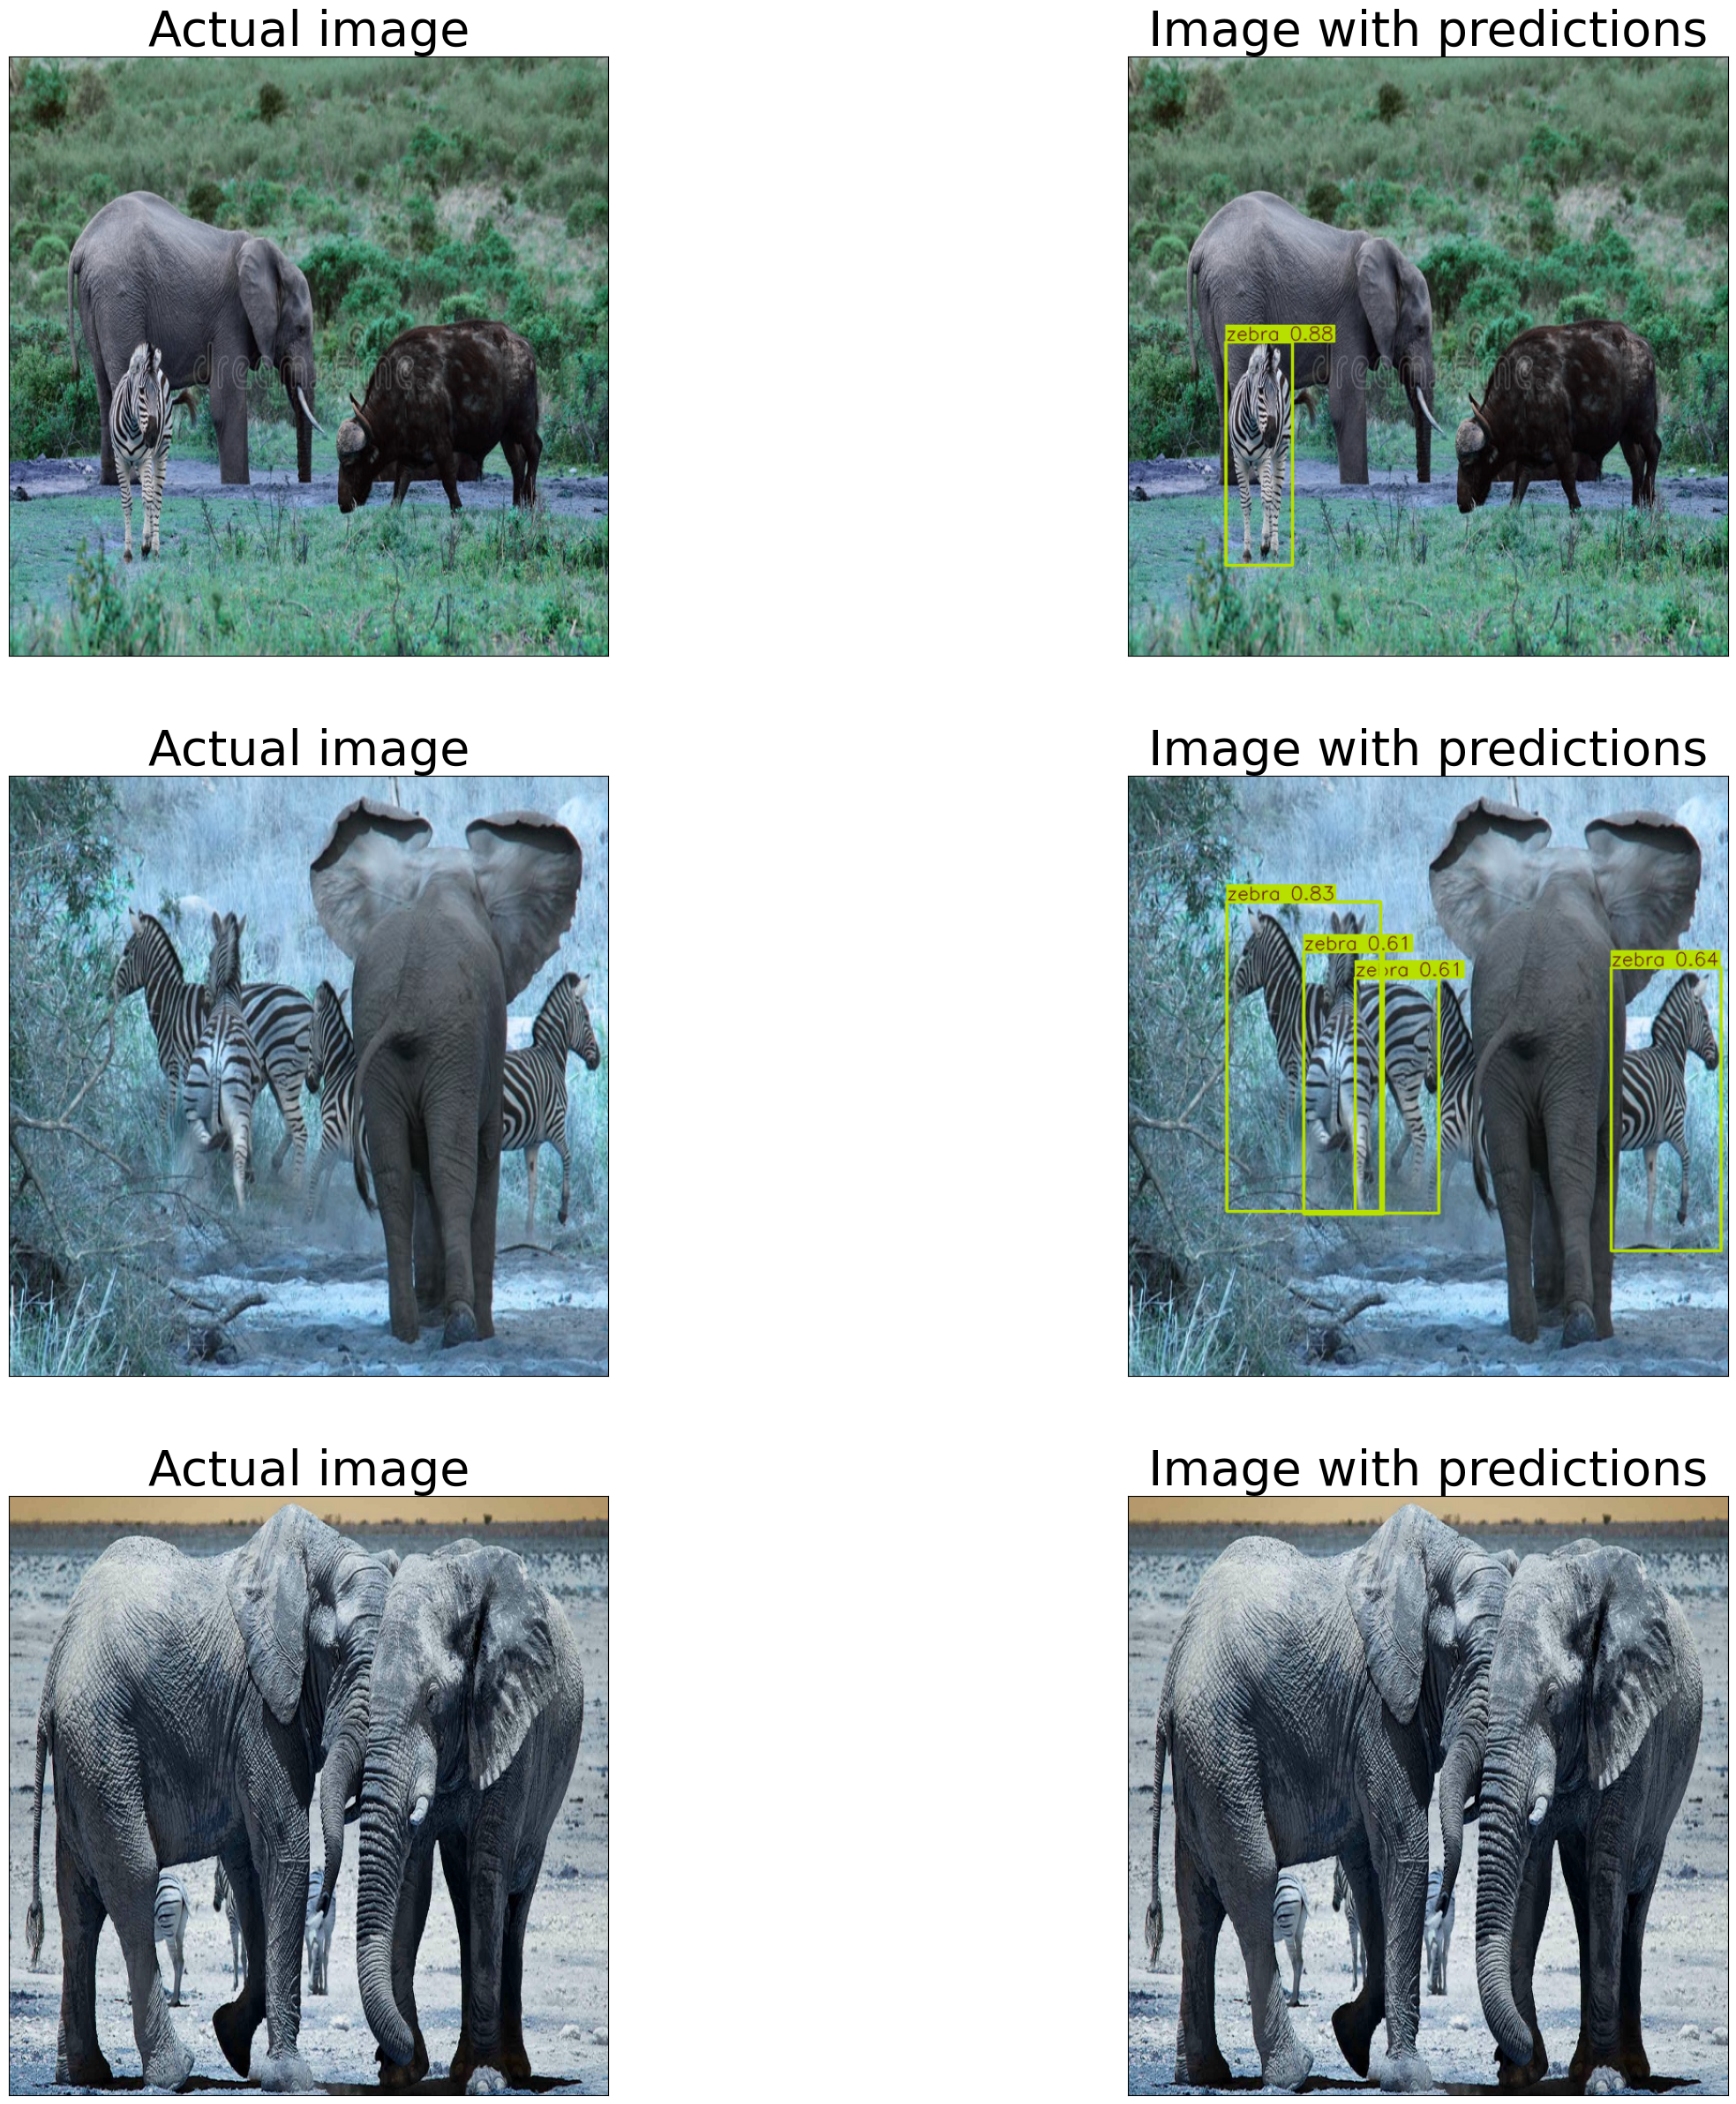

In [70]:
plot_actual_and_predictions(imgtestpath, model,animal = "zebra")

## Conclusion

The model, YOLO v8 we fine tuned perform well in general. Zebra, the two classes with weaker performance can be deteceted as well in testing.